![title](./media/Header.jpeg)

<h1><center>Covid-19 Tweet Clustering </center></h1>



## Indíce
* [Introducción: Presentación del proyecto](#sarrera)
* [Datos](#datuak)
* [Data pre-processing](#dpr)
    * [Visualización de los datos](#ikuskapena)
    * [Adaptación de los datos](#moldaketa)
* [Exploratory Data Analysis](#exploratory)
* [K-Means Algorithm](#kmeans)
* [Inferencia del Algoritmo](#kmeans)


# Introducción: Presentación del proyecto <a name="sarrera"></a>

In [164]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import missingno as msg
import string
import re
import nltk
from scipy import spatial
from spellchecker import SpellChecker
from nltk.corpus import stopwords
from sklearn import preprocessing
from collections import Counter
from wordcloud import WordCloud
from nltk.stem import WordNetLemmatizer
from scipy.spatial import distance
from imageio import imread
import pickle
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.datasets import make_blobs
import random
import math
from gensim.models.doc2vec import Doc2Vec, TaggedDocument
from nltk.tokenize import word_tokenize
import gensim

<hr>

# Datos <a name="datuak"></a>

In [165]:
df = pd.read_csv("./preprocess.csv", engine='python')

<hr>

# Data pre-processing <a name="dpr"></a>

## Visualización de los datos <a name="ikuskapena"></a>

Primero, vamos a mirar los datos para tratar los valores nulos

In [166]:
missing_data = df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 199 entries, 0 to 198
Data columns (total 2 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   OriginalTweet  199 non-null    object
 1   Sentiment      199 non-null    object
dtypes: object(2)
memory usage: 3.2+ KB


<AxesSubplot:>

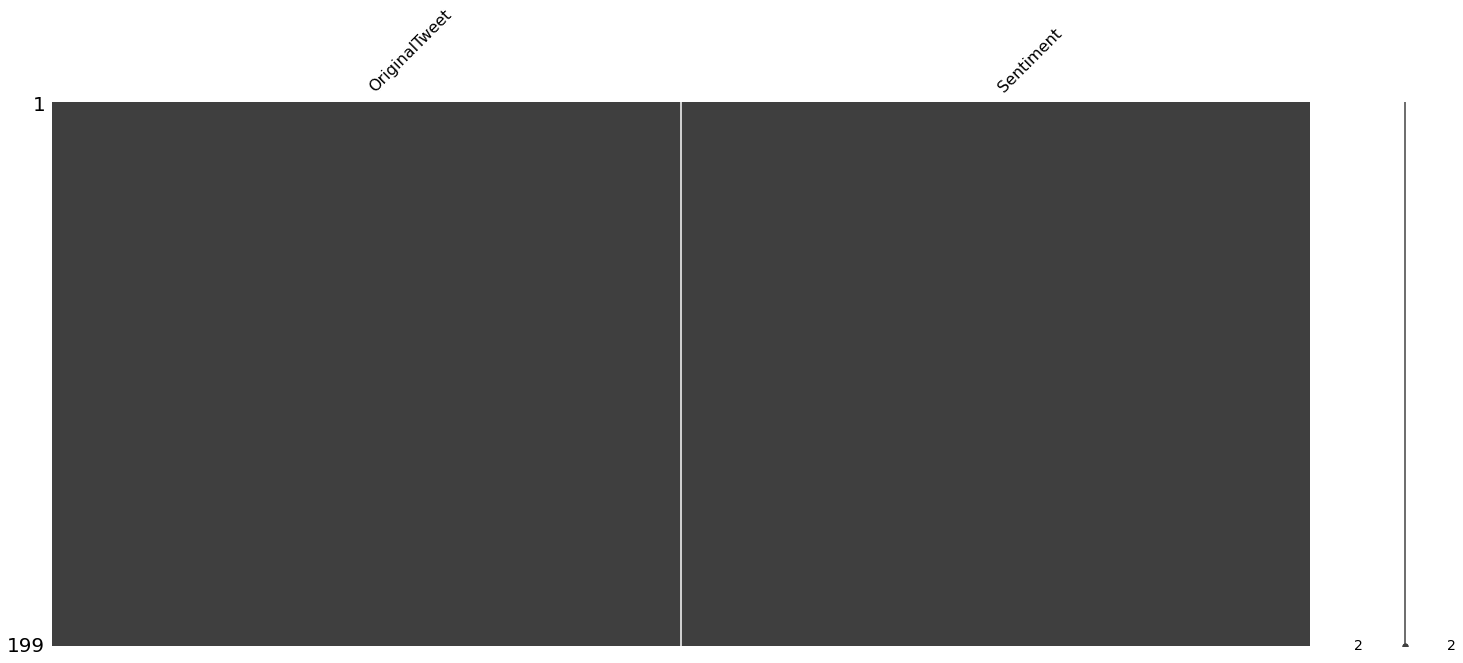

In [167]:
msg.matrix(df)

Como se puede apreciar, no encontramos ninguna entidad con un valor NaN

## Adaptación de los datos<a name="moldaketa"></a>
### Hemos dividido el preprocessing en diez pasos diferentes:
1. Borrar las URL
2. Transformar los emoticonos
3. Transformar los emojis
4. Transformar las abreviaciones
5. Pasar todo a minúsculas
6. Quitar los stopwords
7. Quitar las marcas de puntuacion
8. Corregir palabras
9. Lemmanization
10. Corregir palabras

### 1.Borrar las URL
En los tweets podemos encontrar URL-s las cuales no no son de utilidad. Es por ello que vamos a eliminarlas.

 <img src="./media/linkCase.png" alt="drawing" width="600"/>

In [168]:
def remove_urls(text):
    url_pattern = re.compile(r'https?://\S+|www\.\S+')
    return url_pattern.sub(r'', text)


In [169]:
df["OriginalTweet"] = df["OriginalTweet"].apply(lambda text: remove_urls(text))

### 2. Transformar los emoticonos
Debajo tenemos comprimida toda la lista de emoticonos: https://unicode.org/emoji/charts/full-emoji-list.html , no nos interesa eliminarnos, ya que pueden incluir información del contexto.


 <img src="./media/emotiCase.png" alt="drawing" width="600"/>

In [170]:
def convert_emojis(text):
    for emot in UNICODE_EMO:
        text = re.sub(
            r'('+emot+')', "_".join(UNICODE_EMO[emot].replace(",", "").replace(":", "").split()), text)
    return text

In [171]:
df["OriginalTweet"] = df["OriginalTweet"].apply(
    lambda text: convert_emojis(text))

NameError: name 'UNICODE_EMO' is not defined

### 3. Transformar los emojis
Vamos a cambiar los emojis tambien. https://github.com/NeelShah18/emot/blob/master/emot/emo_unicode.py

 <img src="./media/emojiCase.png" alt="drawing" width="600"/>

In [ ]:
def convert_emoticons(text):
    for emot in EMOTICONS:
        text = re.sub(u'('+emot+')', "_".join(EMOTICONS[emot].replace(",","").split()), text)
    return text

In [ ]:
df["OriginalTweet"] = df["OriginalTweet"].apply(lambda text: convert_emoticons(text))

### 4. Transformar las abreviaciones
Es muy común que en redes sociales, sobretodo en la habla inglesa, se utilicen abreviacionen. Estas pueden ofrecernos informacion interesante, es por ello que vmaos a transformarlas a frases hechas.
BRB = Be right back
CYA = See you later

In [ ]:
chat_words_str = """
AFAIK=As Far As I Know
AFK=Away From Keyboard
ASAP=As Soon As Possible
ATK=At The Keyboard
ATM=At The Moment
A3=Anytime, Anywhere, Anyplace
BAK=Back At Keyboard
BBL=Be Back Later
BBS=Be Back Soon
BFN=Bye For Now
B4N=Bye For Now
BRB=Be Right Back
BRT=Be Right There
BTW=By The Way
B4=Before
B4N=Bye For Now
CU=See You
CUL8R=See You Later
CYA=See You
FAQ=Frequently Asked Questions
FC=Fingers Crossed
FWIW=For What It's Worth
FYI=For Your Information
GAL=Get A Life
GG=Good Game
GN=Good Night
GMTA=Great Minds Think Alike
GR8=Great!
G9=Genius
IC=I See
ICQ=I Seek you (also a chat program)
ILU=ILU: I Love You
IMHO=In My Honest/Humble Opinion
IMO=In My Opinion
IOW=In Other Words
IRL=In Real Life
KISS=Keep It Simple, Stupid
LDR=Long Distance Relationship
LMAO=Laugh My A.. Off
LOL=Laughing Out Loud
LTNS=Long Time No See
L8R=Later
MTE=My Thoughts Exactly
M8=Mate
NRN=No Reply Necessary
OIC=Oh I See
PITA=Pain In The A..
PRT=Party
PRW=Parents Are Watching
ROFL=Rolling On The Floor Laughing
ROFLOL=Rolling On The Floor Laughing Out Loud
ROTFLMAO=Rolling On The Floor Laughing My A.. Off
SK8=Skate
STATS=Your sex and age
ASL=Age, Sex, Location
THX=Thank You
TTFN=Ta-Ta For Now!
TTYL=Talk To You Later
U=You
U2=You Too
U4E=Yours For Ever
WB=Welcome Back
WTF=What The F...
WTG=Way To Go!
WUF=Where Are You From?
W8=Wait...
7K=Sick:-D Laugher
"""

In [ ]:
chat_words_map_dict = {}
chat_words_list = []
for line in chat_words_str.split("\n"):
    if line != "":
        cw = line.split("=")[0]
        cw_expanded = line.split("=")[1]
        chat_words_list.append(cw)
        chat_words_map_dict[cw] = cw_expanded
chat_words_list = set(chat_words_list)

def chat_words_conversion(text):
    new_text = []
    for w in text.split():
        if w.upper() in chat_words_list:
            new_text.append(chat_words_map_dict[w.upper()])
        else:
            new_text.append(w)
    return " ".join(new_text)

### 5. Pasar todo a minusculas

Para que sea mas sencillo el procesamiento del texto, vamos a trasnformar todas las frases a minusculas.

In [ ]:
df["OriginalTweet"] = df["OriginalTweet"].str.lower()

### 6. Quitar los stopwords

Las conocidas como "palabras vacias" son aquellas que no nos van a aportar ninguna información, es por ello que vamos a eliminaras.


In [ ]:
", ".join(stopwords.words('english'))

In [ ]:
STOPWORDS = set(stopwords.words('english'))
STOPWORDS.add('u')
def remove_stopwords(text):
    """custom function to remove the stopwords"""
    return " ".join([word for word in str(text).split() if word not in set(stopwords.words('english'))])

df["OriginalTweet"] = df["OriginalTweet"].apply(lambda text:remove_stopwords(text))

In [ ]:
df["OriginalTweet"] = df["OriginalTweet"].apply(lambda text:remove_stopwords(text))

### 7. Quitar las marcas de puntuacion

Las marcas de puntuación no son relevantes, por tanto vamos a eliminarlo.

In [ ]:
print(df["OriginalTweet"][12])

In [ ]:
def remove_punctuation(text:str):
    """custom function to remove the punctuation"""
    PUNCT_TO_REMOVE = string.punctuation
    PUNCT_TO_REMOVE += 'â’'
    spaces = ''
    for i in range(len(PUNCT_TO_REMOVE)):
        spaces += ' '
    return text.translate(bytes.maketrans(PUNCT_TO_REMOVE, spaces))


In [ ]:
df["OriginalTweet"] = df["OriginalTweet"].apply(lambda text: remove_punctuation(text))

In [ ]:
print(df["OriginalTweet"][12])

### 8. Corregir las palabras

In [ ]:
df['OriginalTweet'] = df['OriginalTweet'].map(lambda x: re.sub('[^A-Za-z ]+', '', x))

In [ ]:
print(df["OriginalTweet"][12])



Puede ocurrir que algunas palabras esten mal escritas, es por eso que las vamos a corregir


In [ ]:
spell = SpellChecker()
def correct_spellings(text):
    corrected_text = []
    misspelled_words = spell.unknown(text.split())
    for word in text.split():
        if word in misspelled_words:
            corrected_text.append(spell.correction(word))
        else:
            corrected_text.append(word)
    return " ".join(corrected_text)

In [ ]:
df["OriginalTweet"] = df["OriginalTweet"].apply(lambda text: correct_spellings(text))

### 9. Lemmanization

En este proceso, lemmanizamos las palabras, lo cual trata de eliminar las posibles conjugaciones. Mas información en el siguiente link: https://en.wikipedia.org/wiki/Lemmatisation

In [ ]:
lemmatizer = WordNetLemmatizer()
def lemmatize_words(text):
    return " ".join([lemmatizer.lemmatize(word) for word in text.split()])

df["OriginalTweet"] = df["OriginalTweet"].apply(lambda text: lemmatize_words(text))

### 10. Corregir palabras

Es posible que despues de todo este proceso, algunas palabras se hayan "corrompido", es por eso que vamos a volver a corregirlas.

In [ ]:
spell = SpellChecker()
def correct_spellings(text):
    corrected_text = []
    misspelled_words = spell.unknown(text.split())
    for word in text.split():
        if word in misspelled_words:
            corrected_text.append(spell.correction(word))
        else:
            corrected_text.append(word)
    return " ".join(corrected_text)

In [ ]:
df["OriginalTweet"] = df["OriginalTweet"].apply(lambda text: correct_spellings(text))

In [ ]:
df.to_csv("../csv/data_preprocess.csv", index=False)

<hr>

# Exploratory Data Analisis <a name="exploratory"></a>

Vamos a utilizar esta sección para analizar los datos y ver si podemos extraer algo de información relevante de esta.

### Datos estadisticos
Vamos a analizar los datos estadísticos, para comprobar si podemos extraer alguna información relevante del conjunto de datos.

In [106]:
df = pd.read_csv("preprocess.csv")
y = df['Sentiment']
df = df.drop('Sentiment',axis=1,inplace=True)

Los diferentes valores de la clase y sus frecuencias

<AxesSubplot:>

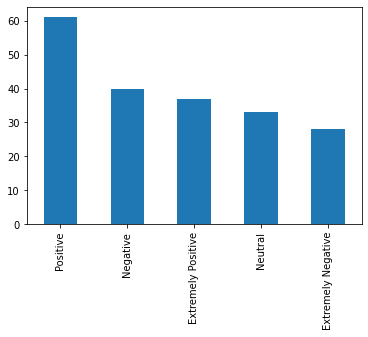

In [107]:
y.value_counts().plot(kind='bar')

In [108]:
y.describe()

count          199
unique           5
top       Positive
freq            61
Name: Sentiment, dtype: object

In [109]:
df = pd.read_csv("preprocess.csv")
df.drop("Sentiment",axis=1,inplace=True)

### Palabras mas utillizadas

In [110]:
STOPWORDS = set(stopwords.words('english'))
STOPWORDS.add('u') #Konponketa 'u' hitza kontuan ez izateko.
def remove_stopwords(text):
    """custom function to remove the stopwords"""
    return " ".join([word for word in str(text).split() if word not in set(STOPWORDS)])

df["OriginalTweet"] = df["OriginalTweet"].apply(lambda text:remove_stopwords(text))
df['OriginalTweet'] = df['OriginalTweet'].replace({'couid': 'covid'}, regex=True) #Esta transormacion no es valida.
df['OriginalTweet'] = df['OriginalTweet'].replace({'amp': ' '}, regex=True) #& Otro caso de error


In [111]:
cnt = Counter()
for text in df["OriginalTweet"].values:
    for word in text.split():
        cnt[word] += 1  
cnt.most_common(30)

[('covid', 143),
 ('coronavirus', 87),
 ('food', 62),
 ('store', 53),
 ('shopping', 38),
 ('online', 33),
 ('people', 32),
 ('supermarket', 30),
 ('panic', 29),
 ('grocery', 26),
 ('consumer', 26),
 ('need', 25),
 ('retail', 25),
 ('stock', 22),
 ('please', 16),
 ('get', 15),
 ('like', 15),
 ('buy', 14),
 ('due', 14),
 ('everyone', 13),
 ('help', 13),
 ('buying', 13),
 ('work', 13),
 ('go', 12),
 ('toilet', 12),
 ('business', 12),
 ('spread', 12),
 ('time', 12),
 ('delivery', 12),
 ('supply', 11)]

### Word cloud

In [112]:
df['label'] = y
df_negative = df[df["label"]=="Negative"] #Dataframes dependiendo de la clase
df_neutral = df[df["label"]=="Neutral"]
df_positive = df[df["label"]=="Positive"]
df_extremely_positive = df[df["label"]=="Extremely Positive"]
df_extremely_negative = df[df["label"]=="Extremely Negative"]


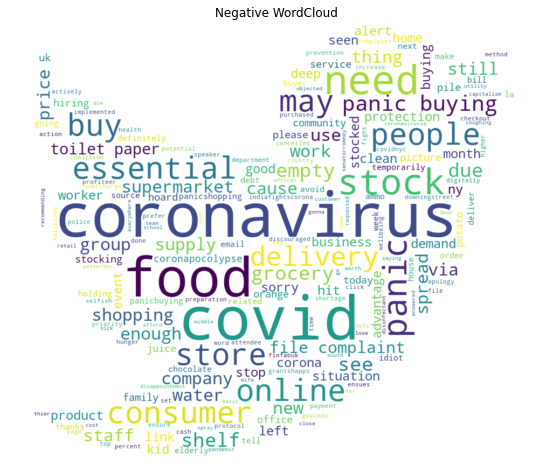

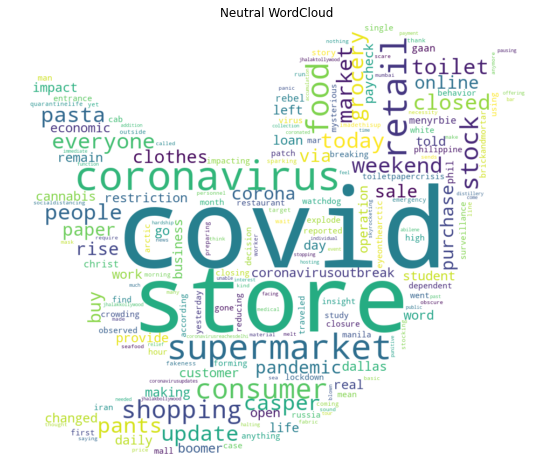

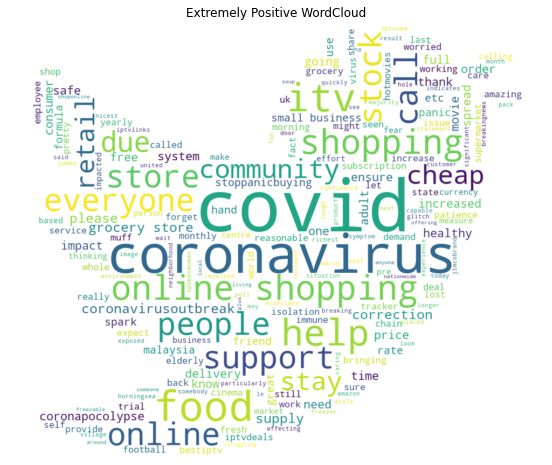

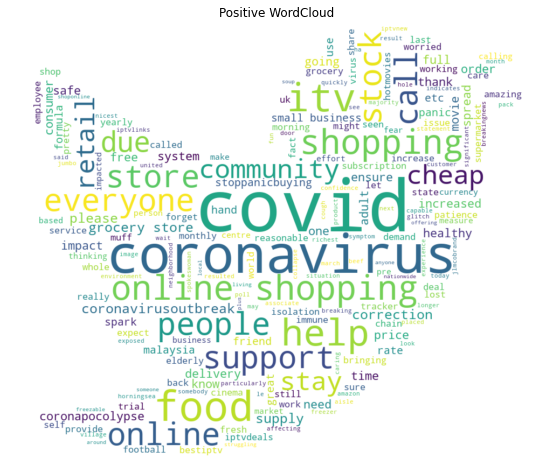

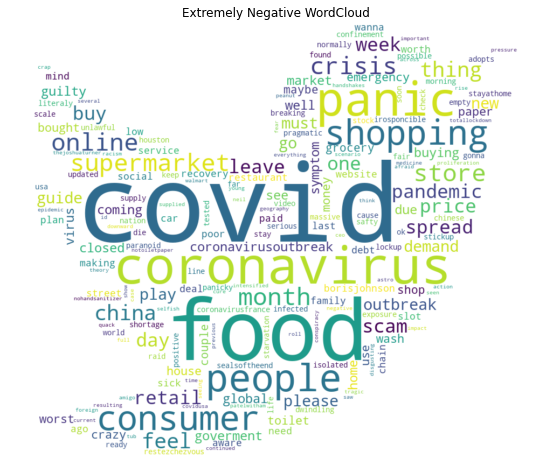

In [113]:
twitter_mask = imread('./media/twitter_mask.png')

wc_negative = WordCloud(background_color='white',width=1800,height=1400,mask=twitter_mask).generate(' '.join(df_negative['OriginalTweet']))
plt.figure(figsize=(10,8))
plt.imshow(wc_negative, interpolation='bilinear')
plt.title("Negative WordCloud")
plt.axis("off")
    
wc_neutral = WordCloud(background_color='white',width=1800,height=1400,mask=twitter_mask).generate(' '.join(df_neutral['OriginalTweet']))
plt.figure(figsize=(10,8))
plt.imshow(wc_neutral, interpolation='bilinear')
plt.title("Neutral WordCloud")
plt.axis("off")

wc_positive = WordCloud(background_color='white',width=1800,height=1400,mask=twitter_mask).generate(' '.join(df_extremely_positive['OriginalTweet']))
plt.figure(figsize=(10,8))
plt.imshow(wc_positive, interpolation='bilinear')
plt.title("Extremely Positive WordCloud")
plt.axis("off")
plt.show()


wc_extremely_positive = WordCloud(background_color='white',width=1800,height=1400,mask=twitter_mask).generate(' '.join(df_positive['OriginalTweet']))
plt.figure(figsize=(10,8))
plt.imshow(wc_positive, interpolation='bilinear')
plt.title("Positive WordCloud")
plt.axis("off")
plt.show()


wc_positive = WordCloud(background_color='white',width=1800,height=1400,mask=twitter_mask).generate(' '.join(df_extremely_negative['OriginalTweet']))
plt.figure(figsize=(10,8))
plt.imshow(wc_positive, interpolation='bilinear')
plt.title("Extremely Negative WordCloud")
plt.axis("off")
plt.show()


<hr>

# Document Embedding

En el proyecto del año pasado, decidimos hacer TF-IDF, este año, hemos decidido ir un paso mas adelante, utilizando Document Embedding.

In [114]:
df = pd.read_csv("preprocess.csv")
# df = df.head(200)
# df.drop(columns=["OriginalTweet", "CleanOriginalTweet"],inplace=True)
# y = df['label']
# df.drop("label",axis=1,inplace=True)
# df = df.iloc[: , 1:]

Vamos a generar la lista de tweets del dataset

In [115]:
lista = [str(i) for i in df['OriginalTweet'].copy().array]

El formato que admite Gensim es TaggedDocummet, por tanto vamos a cambiarlo

In [116]:
tagged_data = [TaggedDocument(words=word_tokenize(_d.lower()), tags=[str(i)]) for i, _d in enumerate(lista)]

Entrenamos el modelo

In [117]:
model = Doc2Vec(documents=tagged_data, min_count=20,vector_size = 200,workers = 2)

Lo de abajo pone como funciona. Como el entrenamiento demora, tenemos un fichero creado que lo carga directamente

In [118]:
from gensim.test.utils import get_tmpfile
model.save("doc_2vec_model_dummy")
model = Doc2Vec.load("doc_2vec_model_dummy")  # you can continue training with the loaded model!

In [119]:
model = Doc2Vec.load("doc_2vec_model_dummy") # El modelo ya esta creado, por tanto solo vamos a cargarlo

Vamos a generar el dataframe con el embedding de todas las instancias

In [120]:
df_test = pd.DataFrame(columns=list(range(200)),index=list(range(199)))

In [121]:
tagged_df = pd.Series( (v[0] for v in tagged_data))
cosas = tagged_df.apply(model.infer_vector)

In [122]:
for i in range(df.shape[0]):
    df_test.loc[i] = pd.Series(cosas[i])

In [123]:
df = df_test


## TSNE Representation of the data after embedding

Vamos a utilizar TSNE para representar nuestros datos

In [124]:
from sklearn.manifold import TSNE
tsne = TSNE(n_components=3, verbose=1, perplexity=40, n_iter=500)
tsne_results = tsne.fit_transform(df)

[t-SNE] Computing 121 nearest neighbors...
[t-SNE] Indexed 199 samples in 0.000s...
[t-SNE] Computed neighbors for 199 samples in 0.004s...
[t-SNE] Computed conditional probabilities for sample 199 / 199
[t-SNE] Mean sigma: 0.005728
[t-SNE] KL divergence after 250 iterations with early exaggeration: 152.232727
[t-SNE] KL divergence after 500 iterations: 2.808416


In [125]:
df['tsne-2d-one'] = tsne_results[:,0]
df['tsne-2d-two'] = tsne_results[:,1]
df['tsne-2d-three'] = tsne_results[:,2]
df['label'] = y

In [126]:
df

,0,1,2,3,4,5,6,7,8,9,...,194,195,196,197,198,199,tsne-2d-one,tsne-2d-two,tsne-2d-three,label
0,0.000535486,-0.00176559,0.00132185,-0.000406708,-0.000554855,0.000481232,0.0012875,-0.000985821,0.000195395,0.00128242,...,-0.00169291,0.00158956,-0.00228626,0.000898238,0.000857152,-0.00164881,1.677481,10.005777,-54.085930,Neutral
1,0.00130911,-0.00226521,-0.0016503,-0.00195517,0.000144909,-0.000236499,0.00176076,-0.000791475,0.000480209,0.00142075,...,-0.000264025,0.00136714,-0.00209267,-0.000340873,-0.0012421,0.00234287,16.486599,56.546429,30.612072,Positive
2,0.00251799,-0.000663284,-0.000345888,0.00193408,0.00189191,-7.3774e-05,-0.00130505,0.00174731,0.000348187,-0.00162275,...,0.000240338,-0.000529786,0.00206725,0.000118261,-0.00210056,-0.000958648,-47.815773,39.234509,89.409859,Positive
3,0.00191161,0.00245848,-0.00212849,-0.0017006,-0.000916958,9.97326e-05,-0.000799722,0.000486001,0.000497047,-0.000320977,...,0.00194797,0.00110987,0.0017606,-0.00241349,-0.00068967,-0.000217654,-17.295610,61.490639,22.218018,Positive
4,0.000844555,-0.00231476,-0.00165302,-0.00229582,-0.00113957,-0.00153305,0.000570601,-0.00176546,-0.00112883,-0.000180935,...,-0.00151833,-0.0007772,-0.00016974,-0.00190249,-0.000891178,-0.00106635,37.874393,-75.673576,-43.291000,Extremely Negative
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
194,0.00159416,-0.000418469,-0.00218561,0.00191751,-0.000415893,0.00124166,0.00135481,-0.000689297,0.00108707,-6.17675e-05,...,0.00150177,0.00100378,0.00199695,0.00011337,-0.00264343,0.00227556,-41.733654,-36.582180,-30.765221,Neutral
195,0.00135446,0.00144782,0.00133209,0.00142704,-0.00127423,0.00192498,-0.00182214,0.00230313,0.00100624,0.000891061,...,0.000471688,-0.002146,0.00250847,-0.00247777,-0.002592,-0.000862965,46.562305,-50.290718,-19.200066,Extremely Positive
196,-0.00234514,-0.000525815,0.00073855,0.00250088,-0.000171734,-0.00189858,8.20381e-05,0.00122441,0.00227565,0.0011877,...,-0.00239837,-0.00194688,-0.000972288,0.00246027,-0.00211575,0.00204263,126.888351,-48.674339,39.559795,Neutral
197,0.00137904,0.000285876,0.00216041,0.000981475,-0.00199059,-0.000535301,1.25199e-05,0.00173346,0.000339653,-0.000292444,...,0.000357986,-0.000973292,-0.0018202,-0.000941496,-0.000447404,-0.000716897,27.130732,58.970352,73.824860,Extremely Positive


In [127]:
df_tsn = df.filter(['tsne-2d-one', 'tsne-2d-two','tsne-2d-three','label'])
df_tsn

,tsne-2d-one,tsne-2d-two,tsne-2d-three,label
0,1.677481,10.005777,-54.085930,Neutral
1,16.486599,56.546429,30.612072,Positive
2,-47.815773,39.234509,89.409859,Positive
3,-17.295610,61.490639,22.218018,Positive
4,37.874393,-75.673576,-43.291000,Extremely Negative
...,...,...,...,...
194,-41.733654,-36.582180,-30.765221,Neutral
195,46.562305,-50.290718,-19.200066,Extremely Positive
196,126.888351,-48.674339,39.559795,Neutral
197,27.130732,58.970352,73.824860,Extremely Positive


#### Recomendamos ejecutar la celda de abajo!!

In [128]:

import plotly.express as px
fig = px.scatter_3d(df_tsn, x='tsne-2d-one', y='tsne-2d-two', z='tsne-2d-three',
              color='label')
fig.show()

Esta representación es un indicio de que nuestro embedding no tiene una clara separación intra-cluster. 

<AxesSubplot:xlabel='tsne-2d-one', ylabel='tsne-2d-two'>

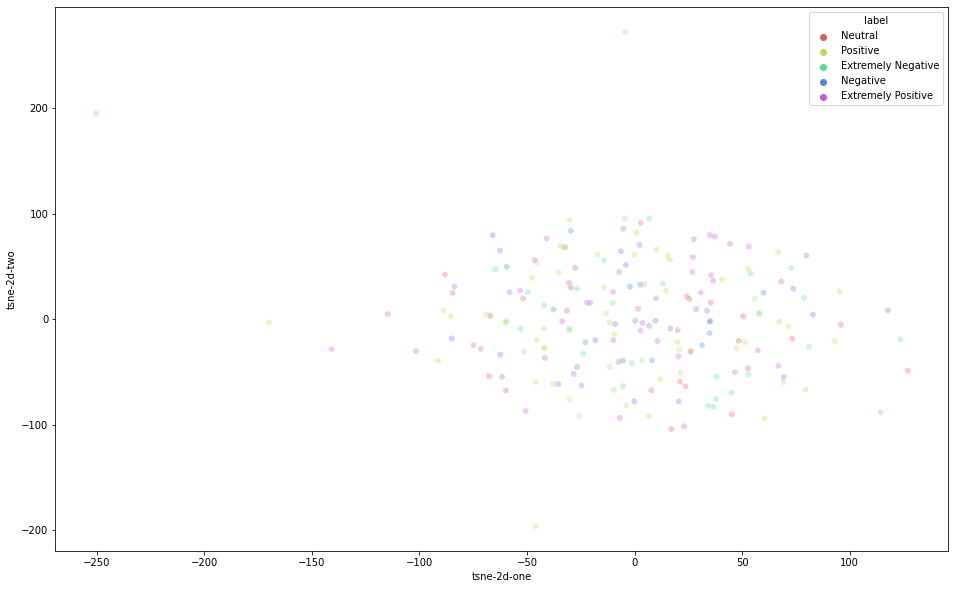

In [129]:
plt.figure(figsize=(16,10))
sns.scatterplot(
    x="tsne-2d-one", y="tsne-2d-two",
    hue="label",
    palette=sns.color_palette("hls", 5),
    data=df,
    legend="full",
    alpha=0.3
)

## PCA Representation of the data after embedding

In [130]:
pca = PCA(n_components=3)

In [131]:
df.drop(columns=["tsne-2d-one", "tsne-2d-two", "tsne-2d-three", "label"], inplace=True)

Normalizamos los datos para generar una distribución normal en los datos y asegurar el correcto funcionamiento del PCA

In [132]:
X = StandardScaler().fit_transform(df.to_numpy())

In [133]:
X_d = pca.fit_transform(X)

In [134]:
principalDf = pd.DataFrame(X_d, columns = ['principal component 1', 'principal component 2', 'principal component 3'])
principalDf["label"] = y

In [135]:
principalDf

,principal component 1,principal component 2,principal component 3,label
0,-1.942344,0.056418,1.593811,Neutral
1,0.345160,-1.946601,-2.908452,Positive
2,-1.590717,-0.088266,-1.467994,Positive
3,-2.618823,2.178437,-1.686274,Positive
4,2.164114,0.381403,-2.589156,Extremely Negative
...,...,...,...,...
194,4.004100,1.137012,1.016092,Neutral
195,3.621132,3.025304,-2.339920,Extremely Positive
196,0.771581,-3.027499,4.125921,Neutral
197,-0.800943,-1.319638,-0.473477,Extremely Positive


<AxesSubplot:xlabel='principal component 1', ylabel='principal component 2'>

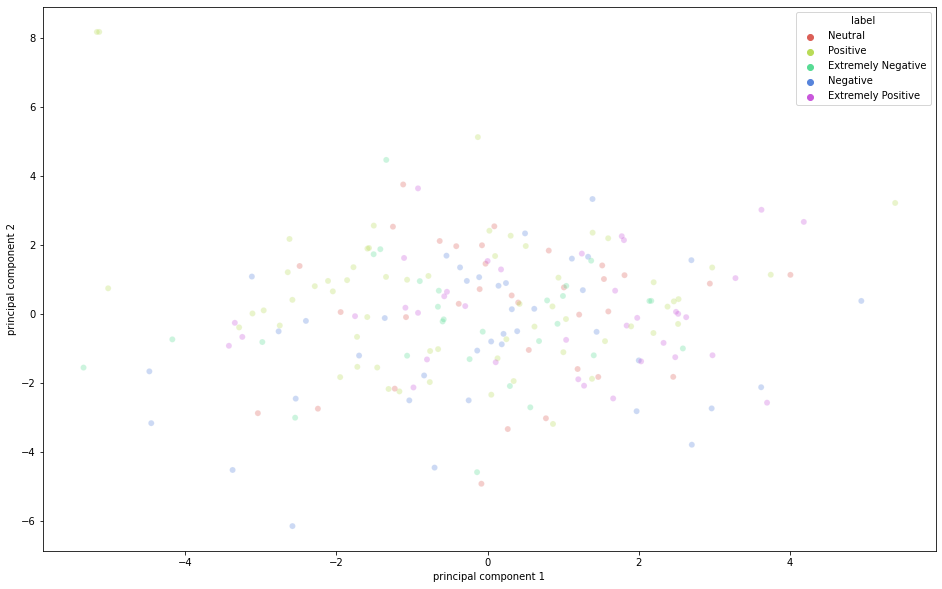

In [136]:
import seaborn as sns
plt.figure(figsize=(16,10))
sns.scatterplot(
    x="principal component 1", y="principal component 2",
    hue="label",
    palette=sns.color_palette("hls", 5),
    data=principalDf,
    legend="full",
    alpha=0.3
)

<hr>

In [137]:
import plotly.express as px
fig = px.scatter_3d(principalDf, x='principal component 1', y='principal component 2', z='principal component 3',
              color='label')
fig.show()

<hr>

# K-Means Algorithm <a name="kmeans"></a>

In [138]:
#Number of clusters, number of iterations and early stopping need to be specified beforehand. 
#Number of clusters k 
k  = 5

#Number if iterations till convergence n_iter
n_iter = 150

In [139]:
#Initialize k random centroides. Centroids can not be inizialized on the same point.
def inizialize_centroids(X, k):
    centroids=[] #array with positions of centroids
    temp = []
    i = 0
    while i < k:
        rand = random.randrange(0,X.shape[0]-1) #get an integer between 0 and number of instances
        if rand in temp:
            continue
        else:
            print(f"Points chosen for cluster initialization {rand}") #an instance has been chosen as a centroid
            temp.append(rand) #add that instance to temp to not repeat the same position as centroid
            centroids.append(X[rand]) #add that instance to the centroid
            i = i+1
    return centroids

In [140]:
def assign_cluster(X, centroids, k):
    # Create list of points which are appointed to each cluster
    clusters = [[] for _ in range(k)]

    # Loop through all instances and determine the closest cluster
    for i, j in enumerate(X): 
        closest_centroid = np.argmin(np.sqrt(np.sum((j - centroids) ** 2, axis=1))) #search for the closest distance to a centroid for each instance
        clusters[closest_centroid].append(i) #once we find the closest centroid, append the instance to that centroid's cluster
    return clusters

In [141]:
def determine_new_centroids(k, clusters, X): #once all clusters are determinated, we must recalculate the centroids.
    centroids = np.zeros((k, X.shape[1])) #numpy.zeros creates an array filled with 0s, with the shape of k.
    #print(clusters)
    for i, j in enumerate(clusters): #loops through all clusters
        new_centroid = np.mean(X[j], axis=0) #calculates the mean distance between the instances and centroid of each cluster
        #print(new_centroid)
        centroids[i] = new_centroid #for each clusters assigns the new centroid
    return centroids

In [142]:
def predict_cluster(clusters, X):
    y_pred = np.zeros(X.shape[0]) #create  x=(number of instances) arrays full of 0s

    for i, j in enumerate(clusters):
        for k in j:
            y_pred[k] = i

    return y_pred

In [143]:
def plot_fig(X, y_pred, centroids):
    plt.scatter(X[:, 0], X[:, 1], c=y_pred, s=30, cmap=plt.cm.RdYlGn)
    plt.scatter(centroids[:, 0], centroids[:,1], s=250, marker='*', c='red', edgecolor='black')
    plt.show()

In [144]:
def dunn_index(X, centroids, clusters):
    index = 0
    distance = 0
    inter_cluster_distance = 999999
    intra_cluster_distance = 0
    current_centroid = []
    to_use_centroids = centroids
    to_use_centroids = to_use_centroids.tolist()
    for i in centroids: #find the smallest distance between centroids
        current_centroid = to_use_centroids.pop(0)
        for j in to_use_centroids: 
            current_centroid = np.array(current_centroid)
            j = np.array(j)
            distance = np.linalg.norm(current_centroid-j)
            if distance < inter_cluster_distance:
                inter_cluster_distance = distance
    
    for number_clusters, centroid in enumerate(centroids):
        for index,instance in enumerate(clusters[number_clusters]):
            actual_centroid = centroids[number_clusters]
            actual_instance = X[instance]
            distance = np.linalg.norm(actual_centroid-actual_instance)
            if distance > intra_cluster_distance:
                intra_cluster_distance = distance
  

    index = inter_cluster_distance / intra_cluster_distance 
    
    return index

In [145]:
def elbow_index(X, clusters, centroids):
    index = 0
    for number_clusters, centroid in enumerate(centroids):
        for index,instance in enumerate(clusters[number_clusters]):
            actual_centroid = centroids[number_clusters]
            actual_instance = X[instance]
            distance = np.linalg.norm(actual_centroid-actual_instance)
            index += distance
    return index

## Make predictions

In [146]:
y_pred = []

In [147]:
centroids = []
def generate_centroids(X,k):
    """ Esta funcion calcula los centroides y devuelve la asignación de cada función"""
    centroids = inizialize_centroids(X, k)
    elbow = []
    for i in range(n_iter):
        print(f"Current iteration {i}")
        clusters = assign_cluster(X, centroids, k)
        prev_centroids = centroids
        centroids = determine_new_centroids(k, clusters, X)

        diff = centroids - prev_centroids


        if not diff.any():
            print(f"Termination criterion satisfied in iteration {i}")
            break
    
            # Get label predictions
    return (predict_cluster(clusters, X),centroids)

In [148]:
y_pred,centroids = generate_centroids(X,5) 

Points chosen for cluster initialization 106
Points chosen for cluster initialization 123
Points chosen for cluster initialization 140
Points chosen for cluster initialization 74
Points chosen for cluster initialization 15
Current iteration 0
Current iteration 1
Current iteration 2
Current iteration 3
Current iteration 4
Termination criterion satisfied in iteration 4


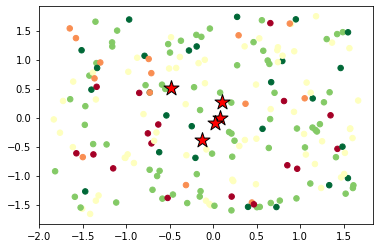

In [149]:
plot_fig(X, y_pred, centroids) # En la imagen salen clusters cuae

La imagen salen clusters de dudosa calidad, siendo asi que la representacion no es la mas adecuada y que los datos no son los optimos. Como demostraremos mas adelante, cada entidad es clasificada correctamente en el cluster adecuado.

In [150]:
y_pred

array([2., 3., 2., 2., 1., 4., 2., 0., 2., 3., 3., 0., 2., 3., 3., 4., 3.,
       4., 4., 2., 3., 3., 3., 4., 4., 1., 3., 3., 4., 2., 2., 2., 0., 3.,
       3., 4., 2., 4., 3., 4., 3., 3., 1., 1., 4., 2., 3., 2., 3., 4., 3.,
       2., 3., 2., 4., 2., 3., 2., 3., 3., 3., 4., 1., 4., 2., 3., 2., 2.,
       2., 1., 2., 3., 2., 3., 3., 3., 3., 2., 2., 2., 0., 0., 3., 4., 0.,
       1., 3., 1., 1., 3., 4., 3., 0., 4., 2., 3., 4., 3., 3., 2., 3., 3.,
       2., 2., 3., 2., 0., 0., 3., 2., 2., 4., 2., 2., 2., 3., 0., 4., 2.,
       0., 2., 2., 2., 1., 2., 2., 3., 2., 3., 3., 4., 3., 3., 1., 3., 4.,
       2., 3., 2., 2., 2., 0., 0., 3., 1., 3., 3., 3., 3., 2., 4., 2., 3.,
       2., 3., 1., 3., 3., 3., 3., 3., 2., 2., 3., 3., 2., 3., 0., 3., 2.,
       2., 0., 3., 3., 4., 2., 2., 3., 2., 2., 3., 3., 1., 0., 3., 2., 3.,
       3., 2., 2., 3., 2., 2., 2., 3., 2., 2., 0., 4.])

Esta es la asignación de cada entidad a su cluster.

<hr>

<div>

# Inference of new instances

In [151]:
model = Doc2Vec.load("doc_2vec_model_dummy")
df_original = pd.read_csv("dummy_original_200.csv")

In [152]:
def preprocess(word):
    words  = re.sub('[^A-Za-z ]+', '', word)
    words = words.translate(str.maketrans('', '', string.punctuation))
    words = remove_stopwords(words)
    words = words.lower()
    return words

In [153]:
def assign_label_with_supervised(word):
    preprocessed = preprocess(word)
    moda = []
    words = preprocessed.split(" ")
    infer = model.infer_vector(words)
    similar_documents = model.dv.most_similar([infer], topn = 3)
    for documents in similar_documents:
        moda.append(df_original.iloc[int(documents[0])]["label"])
    return max(set(moda), key=moda.count)


In [154]:
def assing_label_unsupervised(word:str):
    
    preprocessed = preprocess(word)
    distancias = []
    words = preprocessed.split(" ")
    infer = model.infer_vector(words)
    distancias = []
    for centroid in centroids:
        dst = distance.euclidean(infer,centroid)
        distancias.append(dst)
    index_min = np.argmin(distancias)
    print(distancias)
    print(index_min)

In [155]:
def search_similar_doc(word:str):
    preprocessed = preprocess(word)
    words = preprocessed.split(" ")
    infer = model.infer_vector(words)
    similar_documents = model.dv.most_similar([infer], topn = 10)
    text = []
    clase = []
    for documents in similar_documents:
        text.append(df_original.iloc[int(documents[0])]["OriginalTweet"])
        clase.append(y_pred[int(documents[0])])
    df = pd.DataFrame(text,columns=['Tweet Mas Similar'])
    df['Cluster'] = clase
    return df

### Prueba poner cualquier frase y se le asignara un cluster

Este metodo utiliza los datos supervisados, por tanto no es lo ideal, es por ello que vamos a utilizar los centroides para asignar un cluster

In [160]:
assing_label_unsupervised("pok oko kok okyoan paper of anything that ive done is to make some")

[3.8826021746012325, 4.525434049532124, 2.029402881770202, 1.8297882090305864, 3.324965821399592]
3


Como se ve, clasifica la instancia en el cluster 4

Esta funcion nos devuelve dos valores, uno siendo la frase con el embedding aplicado y lo otro el cluster asignado por nuestro algoritmo de K-means.

In [161]:
df_pred = search_similar_doc("Toilet paper has some valauable #covid love you")

In [162]:
pd.set_option("display.max_colwidth",None)
df_pred.sort_values('Cluster')

,Tweet Mas Similar,Cluster
5,"Due to the Covid-19 situation, we have increased demand for all food products. \n\n\n\nThe wait time may be longer for all online orders, particularly beef share and freezer packs. \n\n\n\nWe thank you for your patience during this time.",0.0
0,.@bbchealth How can someone in a high-risk group distance against #COVID-19 when not enough drivers to deliver online shopping &amp; has no friends or relatives? My position &amp; all here are in same group,2.0
1,'Hole' Foods...\n\n\n\n...images from the nicest grocery store in one of the richest neighborhoods in the United States.\n\n\n\nhttps://t.co/WnQSoMtkVI\n\n\n\n#BreakingNews #Breaking #Coronavirus #CoronavirusOutbreak #COVID19 #COVID?19 #COVID_19 #COVID2019 #Collapse,2.0
2,Corona scare sends sea-food prices skyrocketing in Mumbai\n\n\n\n&gt;&gt; https://t.co/GB11EFBYIB \n\n\n\n#seafood #coronavirus #CoronavirusOutbreak #CoronavirusReachesDelhi #Coronavid19 #CoronaVirusUpdates #COVID2019 #COVID19 #JhalakBollywood #JhalakKollywood #JhalakTollywood https://t.co/U5Dg3LoFYG,2.0
3,What 2K Consumers Told PYMNTS About How COVID-19 Changed Their Daily Lives https://t.co/Ybg8Zupdf6 via @pymnts,2.0
4,"UPDATE: Make sure to check your local listings to see what is open/closed at what times.\n\nChick-fil-A (Drive through only)\n\nStarbucks (Using to-go model)\n\nEarly closing include King Soopers, Sam's Club etc..\n\nhttps://t.co/8yP3x1MH4h",2.0
6,"What's the plan for supplying food @BorisJohnson? The panic buying is crazy and the supermarkets have no slots for delivery. Rationing seems sensible. You can't ""suggest"" (how feeble) we self-isolate for months without telling us how we'll eat. #coronavirus",2.0
8,First shops to make this effort could really win the PR game... and make a real difference. https://t.co/6TqO57Lt0q,2.0
9,Will katie and I be moving in this weekend amongst the COVID 19 panic Yes Will have food or toilet paper No Will we have any self respect Also no but at least we ll have each other,3.0
7,"4. ""Both the masks made for medical personnel and for consumer purchase require a once-obscure material called melt-blown fabric.""\n\n\n\nhttps://t.co/3hCd9IiWoX",4.0


In [163]:
df1 = df_pred[df_pred["Cluster"] == 0.0].head(10)
df2 = df_pred[df_pred["Cluster"] == 1.0].head(10)
df3 = df_pred[df_pred["Cluster"] == 2.0].head(10)
df4 = df_pred[df_pred["Cluster"] == 3.0].head(10)
df5 = df_pred[df_pred["Cluster"] == 4.0].head(10)
df_pred = pd.concat([df1, df2, df3, df4, df5])
df_pred.head(50)

,Tweet Mas Similar,Cluster
5,"Due to the Covid-19 situation, we have increased demand for all food products. \n\n\n\nThe wait time may be longer for all online orders, particularly beef share and freezer packs. \n\n\n\nWe thank you for your patience during this time.",0.0
0,.@bbchealth How can someone in a high-risk group distance against #COVID-19 when not enough drivers to deliver online shopping &amp; has no friends or relatives? My position &amp; all here are in same group,2.0
1,'Hole' Foods...\n\n\n\n...images from the nicest grocery store in one of the richest neighborhoods in the United States.\n\n\n\nhttps://t.co/WnQSoMtkVI\n\n\n\n#BreakingNews #Breaking #Coronavirus #CoronavirusOutbreak #COVID19 #COVID?19 #COVID_19 #COVID2019 #Collapse,2.0
2,Corona scare sends sea-food prices skyrocketing in Mumbai\n\n\n\n&gt;&gt; https://t.co/GB11EFBYIB \n\n\n\n#seafood #coronavirus #CoronavirusOutbreak #CoronavirusReachesDelhi #Coronavid19 #CoronaVirusUpdates #COVID2019 #COVID19 #JhalakBollywood #JhalakKollywood #JhalakTollywood https://t.co/U5Dg3LoFYG,2.0
3,What 2K Consumers Told PYMNTS About How COVID-19 Changed Their Daily Lives https://t.co/Ybg8Zupdf6 via @pymnts,2.0
4,"UPDATE: Make sure to check your local listings to see what is open/closed at what times.\n\nChick-fil-A (Drive through only)\n\nStarbucks (Using to-go model)\n\nEarly closing include King Soopers, Sam's Club etc..\n\nhttps://t.co/8yP3x1MH4h",2.0
6,"What's the plan for supplying food @BorisJohnson? The panic buying is crazy and the supermarkets have no slots for delivery. Rationing seems sensible. You can't ""suggest"" (how feeble) we self-isolate for months without telling us how we'll eat. #coronavirus",2.0
8,First shops to make this effort could really win the PR game... and make a real difference. https://t.co/6TqO57Lt0q,2.0
9,Will katie and I be moving in this weekend amongst the COVID 19 panic Yes Will have food or toilet paper No Will we have any self respect Also no but at least we ll have each other,3.0
7,"4. ""Both the masks made for medical personnel and for consumer purchase require a once-obscure material called melt-blown fabric.""\n\n\n\nhttps://t.co/3hCd9IiWoX",4.0
